# Imports

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    silhouette_score,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn_extra.cluster import KMedoids


# Datasets
Train, Valid, Test

In [2]:
train_df = pd.read_csv('../generated dataset/train.csv')
valid_df = pd.read_csv('../generated dataset/valid.csv')
test_df = pd.read_csv('../generated dataset/test.csv')

In [3]:
train_df.head(5)

,Brightness,Contrast,Mean,Variance,Skewness,Kurtosis,Entropy,Energy,Absolute Moment k=1,Absolute Moment k=2,...,Information Measure I,Information Measure II,Maximal Correlation Coefficient,Short-run Emphasis,Long-run Emphasis,Gray-level Nonuniformity,Difference of Entropy,Second Largest Eigenvalue,Label,Image
0,146.146736,81.409801,146.146736,6627.555637,-0.186254,-1.798750,6.974621,0.011098,146.146736,117.858576,...,1.0,0.0,0.010016,1.0,0.0,0.000006,4.469887,0.015243,Hibiscus,IMG_20241029_131633_jpg.rf.a3f2d7fa633ae0536e8...
1,147.130032,67.900449,147.130032,4610.471012,-0.399389,-1.412432,7.179110,0.010070,147.130032,117.151824,...,1.0,0.0,0.014951,1.0,0.0,0.000007,4.732864,0.020229,Hibiscus,IMG_20241029_131640_jpg.rf.30a12f9b36a51bb91c4...
2,148.789408,73.502056,148.789408,5402.552291,-0.262159,-1.708594,6.882111,0.011922,148.789408,114.736928,...,1.0,0.0,0.012129,1.0,0.0,0.000007,3.966379,0.018935,Hibiscus,IMG_20241029_131646_jpg.rf.c743c72ae1c3b403d16...
3,131.630976,76.952406,131.630976,5921.672749,-0.136606,-1.796559,6.932319,0.010645,131.630976,116.349472,...,1.0,0.0,0.008145,1.0,0.0,0.000005,4.478143,0.012706,Hibiscus,IMG_20241029_131651_jpg.rf.203f579e95e3f696a72...
4,150.084368,60.223102,150.084368,3626.821986,-0.411602,-1.391630,6.861676,0.013588,150.084368,116.505328,...,1.0,0.0,0.017838,1.0,0.0,0.000009,4.438945,0.019402,Hibiscus,IMG_20241029_131711_jpg.rf.c3aee7f34bec54a8830...


In [4]:
X_train, y_train = train_df.drop(columns=['Image', 'Label']), train_df['Label']
X_valid, y_valid = valid_df.drop(columns=['Image', 'Label']), valid_df['Label']
X_test, y_test = test_df.drop(columns=['Image', 'Label']), test_df['Label']

## Scaling to Normalize the Data

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Dimensionality Reduction

### Dimensionality Reduction Techniques

In [6]:
dim_reduction_methods = {
    "PCA": PCA(n_components=2),
    "Isomap": Isomap(n_components=2),
    "Kernel PCA (RBF)": KernelPCA(n_components=2, kernel='rbf'),
    "LLE": LocallyLinearEmbedding(n_components=2),
    "Laplacian Eigenmap": SpectralEmbedding(n_components=2, affinity='nearest_neighbors'),  # Laplacian Eigenmap
    "t-SNE": TSNE(n_components=2)  # Typically used for 2D, adjust components as needed
}

In [7]:
best_model = None
best_model_name = None
best_model_score = float('-inf')  
best_reduction_technique = None

In [8]:
def evaluate_classifiers(name, model, X_train, y_train, X_valid, y_valid, X_test, y_test, dim_red):
    global best_model, best_model_name, best_model_score, best_reduction_technique

    print(f"\nTraining {name} model...")
    model.fit(X_train, y_train)

    # Validation performance
    y_valid_pred = model.predict(X_valid)
    print(f"\nValidation Performance of {name} with dimensionality reduction used as {dim_red}:")
    print(confusion_matrix(y_valid, y_valid_pred))
    
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)
    valid_precision = precision_score(y_valid, y_valid_pred, average='weighted', zero_division=0)
    valid_recall = recall_score(y_valid, y_valid_pred, average='weighted', zero_division=0)
    valid_f1_score = f1_score(y_valid, y_valid_pred, average='weighted', zero_division=0)
    
    print(f'The weighted average of accuracy for validation dataset is: {valid_accuracy:.4f}')
    print(f'The weighted average of precision for validation dataset is: {valid_precision:.4f}')
    print(f'The weighted average of recall for validation dataset is: {valid_recall:.4f}')
    print(f'The weighted average of F1-score for validation dataset is: {valid_f1_score:.4f}')
    
    # Test performance
    y_test_pred = model.predict(X_test)
    print(f"\nTest Performance of {name}  with dimensionality reduction used as {dim_red}:")
    print(confusion_matrix(y_test, y_test_pred))

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    test_f1_score = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    
    print(f'The weighted average of accuracy for test dataset is: {test_accuracy:.4f}')
    print(f'The weighted average of precision for test dataset is: {test_precision:.4f}')
    print(f'The weighted average of recall for test dataset is: {test_recall:.4f}')
    print(f'The weighted average of F1-score for test dataset is: {test_f1_score:.4f}')
    
    # Update the best model if the current model is better (using test F1 score)
    if test_f1_score > best_model_score:
        best_model_score = test_f1_score
        best_model = model
        best_model_name = name
        best_reduction_technique = dim_red
        print(f"\n{name} is the new best model with test F1 score: {test_f1_score:.4f}")

# Evaluating Classifiers

In [9]:
classification_models = {
    'Linear SVM' : SVC(kernel='linear', C=1, random_state=42),
    'Polynomial SVM' : SVC(kernel='poly', degree=3, C=1, random_state=42),
    'RBF SVM' :  SVC(kernel='rbf', C=1, gamma='scale', random_state=42),
    'Logistic Regression' : LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42),
    'Parzen Window' : GaussianNB(),
    'kNN' : KNeighborsClassifier(n_neighbors=5),
    'Decision Tree' : DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest' : RandomForestClassifier(n_estimators=100, random_state=42)
}

In [10]:
for dr_name, method in dim_reduction_methods.items():
    print(f"\nApplying {dr_name}...")
    X_train_reduced = method.fit_transform(X_train)
    X_valid_reduced = method.fit_transform(X_valid)
    X_test_reduced = method.fit_transform(X_test)
    
    for model_name, model in classification_models.items():
        evaluate_classifiers(model_name, model, X_train_reduced, y_train, X_valid_reduced, y_valid, X_test_reduced, y_test, dr_name)
    print('________________________________________________________________')


Applying PCA...

Training Linear SVM model...

Validation Performance of Linear SVM with dimensionality reduction used as PCA:
[[ 0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  6  0  0  0  3  0]
 [ 0  0  1  0  0  0  0  0  4  0]
 [ 0  0  0  0  1  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  3  0]
 [ 0  0  1  0  0  0  0  0  7  0]
 [ 0  0  1  0  0  0  0  0  2  0]
 [ 0  6  7 11 22  2  0  2 11  0]
 [ 0  0  2  1  0  0  0  0  4  0]]
The weighted average of accuracy for validation dataset is: 0.1154
The weighted average of precision for validation dataset is: 0.1614
The weighted average of recall for validation dataset is: 0.1154
The weighted average of F1-score for validation dataset is: 0.1322

Test Performance of Linear SVM  with dimensionality reduction used as PCA:
[[0 0 0 0 0 0 0 0 1]
 [0 0 0 0 2 0 0 0 1]
 [0 0 0 0 2 0 0 0 3]
 [0 0 0 0 0 0 0 0 1]
 [0 1 0 3 3 0 0 0 2]
 [0 0 0 1 0 0 0 0 3]
 [0 0 0 0 2 0 0 0 1]
 [0 0 0 0 2 0 0 0 0]
 [0 0 4 3 3 0 0 0 0]]
The weig

## Printing the Best Classification Model & Dimensionality Reduction

In [11]:
print(f"The best model so far is: {best_model_name} with the f1-score of {best_model_score:.4f}  with dimensionality reduction used as {best_reduction_technique}. ")

The best model so far is: Parzen Window with the f1-score of 0.3395  with dimensionality reduction used as Isomap. 


# Clustering Method

In [12]:
X = pd.concat([train_df, test_df, valid_df], axis=0)
X.head(5)

,Brightness,Contrast,Mean,Variance,Skewness,Kurtosis,Entropy,Energy,Absolute Moment k=1,Absolute Moment k=2,...,Information Measure I,Information Measure II,Maximal Correlation Coefficient,Short-run Emphasis,Long-run Emphasis,Gray-level Nonuniformity,Difference of Entropy,Second Largest Eigenvalue,Label,Image
0,146.146736,81.409801,146.146736,6627.555637,-0.186254,-1.798750,6.974621,0.011098,146.146736,117.858576,...,1.0,0.0,0.010016,1.0,0.0,0.000006,4.469887,0.015243,Hibiscus,IMG_20241029_131633_jpg.rf.a3f2d7fa633ae0536e8...
1,147.130032,67.900449,147.130032,4610.471012,-0.399389,-1.412432,7.179110,0.010070,147.130032,117.151824,...,1.0,0.0,0.014951,1.0,0.0,0.000007,4.732864,0.020229,Hibiscus,IMG_20241029_131640_jpg.rf.30a12f9b36a51bb91c4...
2,148.789408,73.502056,148.789408,5402.552291,-0.262159,-1.708594,6.882111,0.011922,148.789408,114.736928,...,1.0,0.0,0.012129,1.0,0.0,0.000007,3.966379,0.018935,Hibiscus,IMG_20241029_131646_jpg.rf.c743c72ae1c3b403d16...
3,131.630976,76.952406,131.630976,5921.672749,-0.136606,-1.796559,6.932319,0.010645,131.630976,116.349472,...,1.0,0.0,0.008145,1.0,0.0,0.000005,4.478143,0.012706,Hibiscus,IMG_20241029_131651_jpg.rf.203f579e95e3f696a72...
4,150.084368,60.223102,150.084368,3626.821986,-0.411602,-1.391630,6.861676,0.013588,150.084368,116.505328,...,1.0,0.0,0.017838,1.0,0.0,0.000009,4.438945,0.019402,Hibiscus,IMG_20241029_131711_jpg.rf.c3aee7f34bec54a8830...


In [13]:
X = X.drop(columns=['Image', 'Label'])

In [14]:
def mst(X):
    neighbors = NearestNeighbors(n_neighbors=5)
    neighbors.fit(X)
    distances, indices = neighbors.kneighbors(X)

    # Build the minimum spanning tree using the distances
    graph = nx.Graph()

    for i in range(len(X)):
        for j in indices[i]:
            if i != j:  # Avoid self-loop
                graph.add_edge(i, j, weight=distances[i][np.where(indices[i] == j)[0][0]])

    # Find the connected components (clusters) of the MST
    mst = nx.minimum_spanning_tree(graph)
    clusters_mst = list(nx.connected_components(mst))

    mst_labels = np.zeros(len(X))
    for cluster_id, cluster in enumerate(clusters_mst):
        for idx in cluster:
            mst_labels[idx] = cluster_id

    return mst_labels

In [15]:
def evaluate_dim_reduction_and_clustering(X, dim_reduction_methods, clustering_methods, method_names):
    best_score = -1
    best_combination = None
    best_labels = None

    for dim_name, dim_method in dim_reduction_methods.items():
        # Apply dimensionality reduction
        X_reduced = dim_method.fit_transform(X)

        print(f"\nResults for Dimensionality Reduction: {dim_name}\n")
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Create a grid for subplots
        axes = axes.ravel()

        for i, (cluster_method, cluster_name) in enumerate(zip(clustering_methods, method_names)):
            if cluster_name == "MST":
                labels = mst(X_reduced)  # MST function generates labels
            else:
                if cluster_method is None or not hasattr(cluster_method, "fit_predict"):
                    print(f"Skipping invalid clustering method: {cluster_name}")
                    continue
                labels = cluster_method.fit_predict(X_reduced)

            # Handle noise (-1 label in DBSCAN) if applicable
            if -1 in labels:
                X_filtered = X_reduced[labels != -1]
                labels_filtered = labels[labels != -1]
            else:
                X_filtered = X_reduced
                labels_filtered = labels

            # Compute silhouette score
            if len(set(labels_filtered)) > 1:
                silhouette_avg = silhouette_score(X_filtered, labels_filtered)
                print(f"{cluster_name} Silhouette Score: {silhouette_avg:.4f}")
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_combination = (dim_name, cluster_name)
                    best_labels = labels
            else:
                print(f"{cluster_name} could not compute silhouette score because all points belong to a single cluster.")

            # Plot the results
            axes[i].scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', marker='o')
            axes[i].set_title(f"{cluster_name}")
            axes[i].set_xlabel("Component 1")
            axes[i].set_ylabel("Component 2")

        plt.suptitle(f"Clustering Results after {dim_name}")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    # Print the best combination
    print(f"\nBest Combination: {best_combination[0]} + {best_combination[1]} with Silhouette Score: {best_score:.4f}")
    return best_combination, best_labels

In [16]:
dim_reduction_methods = {
    "PCA": PCA(n_components=2),
    "Isomap": Isomap(n_components=2),
    "Kernel PCA (RBF)": KernelPCA(n_components=2, kernel='rbf'),
    "LLE": LocallyLinearEmbedding(n_components=2),
    "Laplacian Eigenmap": SpectralEmbedding(n_components=2, affinity='nearest_neighbors'),
    "t-SNE": TSNE(n_components=2)
}

In [17]:
clustering_methods = [
    KMeans(n_clusters=10, random_state=42),
    KMedoids(n_clusters=10, random_state=42),
    DBSCAN(eps=0.5, min_samples=5),
    AgglomerativeClustering(n_clusters=10, linkage='ward'),
    None,  # Placeholder if more methods are to be added later
]

In [18]:
method_names = ["K-Means", "K-Medoids", "DBSCAN", "AgglomerativeClustering", "MST"]


Results for Dimensionality Reduction: PCA

K-Means Silhouette Score: 0.5007
K-Medoids Silhouette Score: 0.4404
DBSCAN could not compute silhouette score because all points belong to a single cluster.
AgglomerativeClustering Silhouette Score: 0.4780
MST could not compute silhouette score because all points belong to a single cluster.


c:\Users\ramte\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


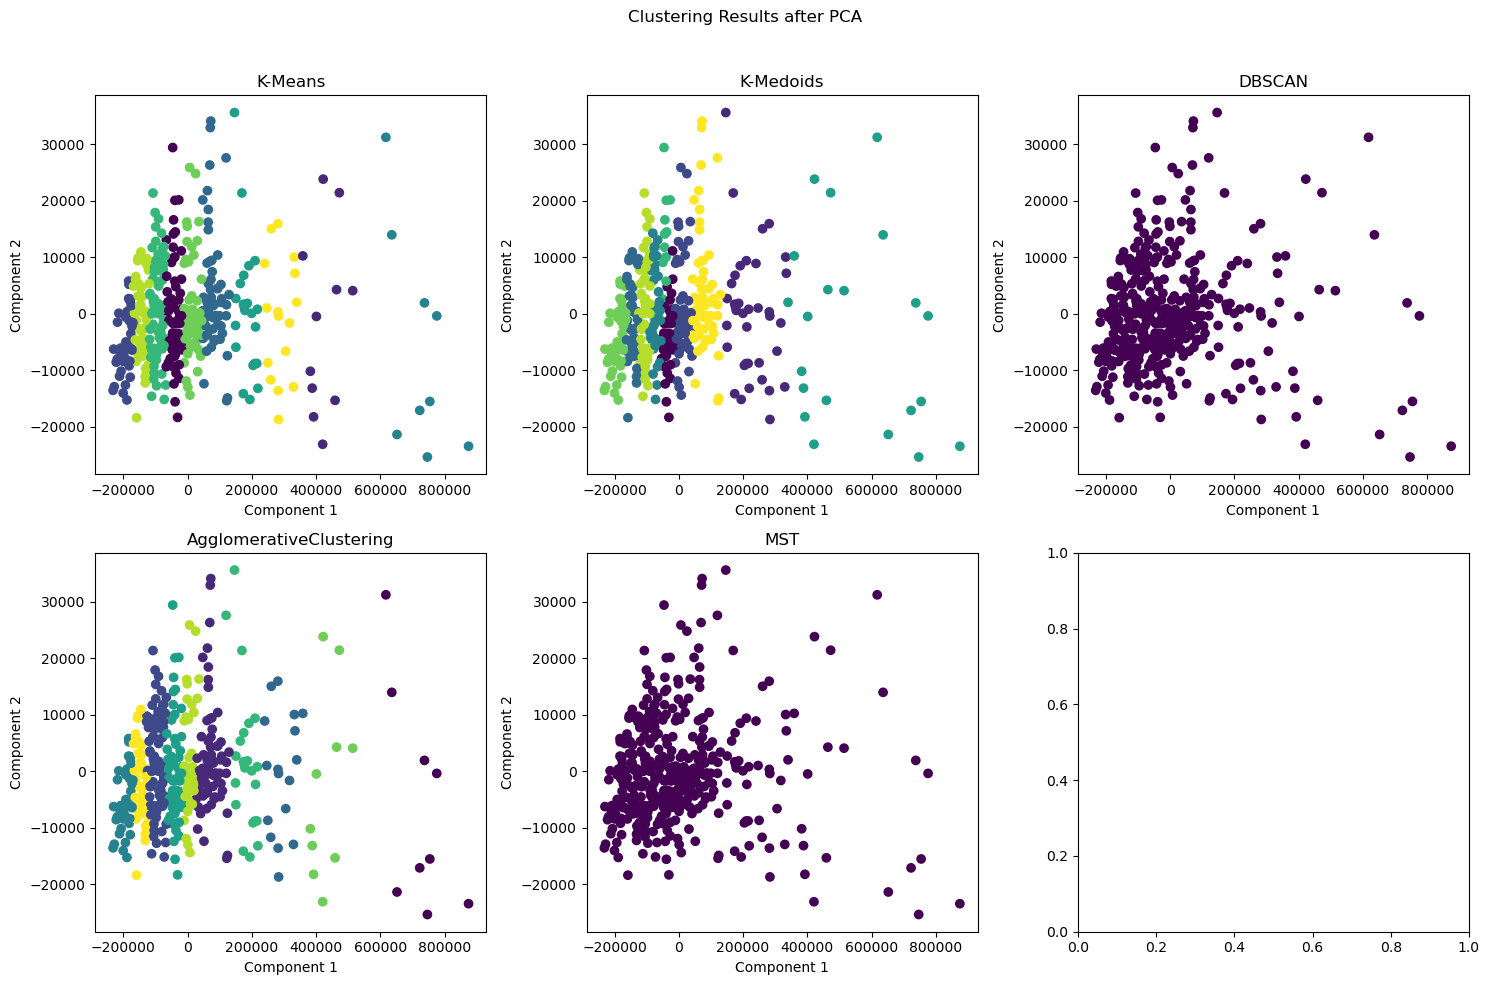


Results for Dimensionality Reduction: Isomap

K-Means Silhouette Score: 0.4878
K-Medoids Silhouette Score: 0.3820
DBSCAN could not compute silhouette score because all points belong to a single cluster.
AgglomerativeClustering Silhouette Score: 0.4752
MST Silhouette Score: 0.1690


c:\Users\ramte\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


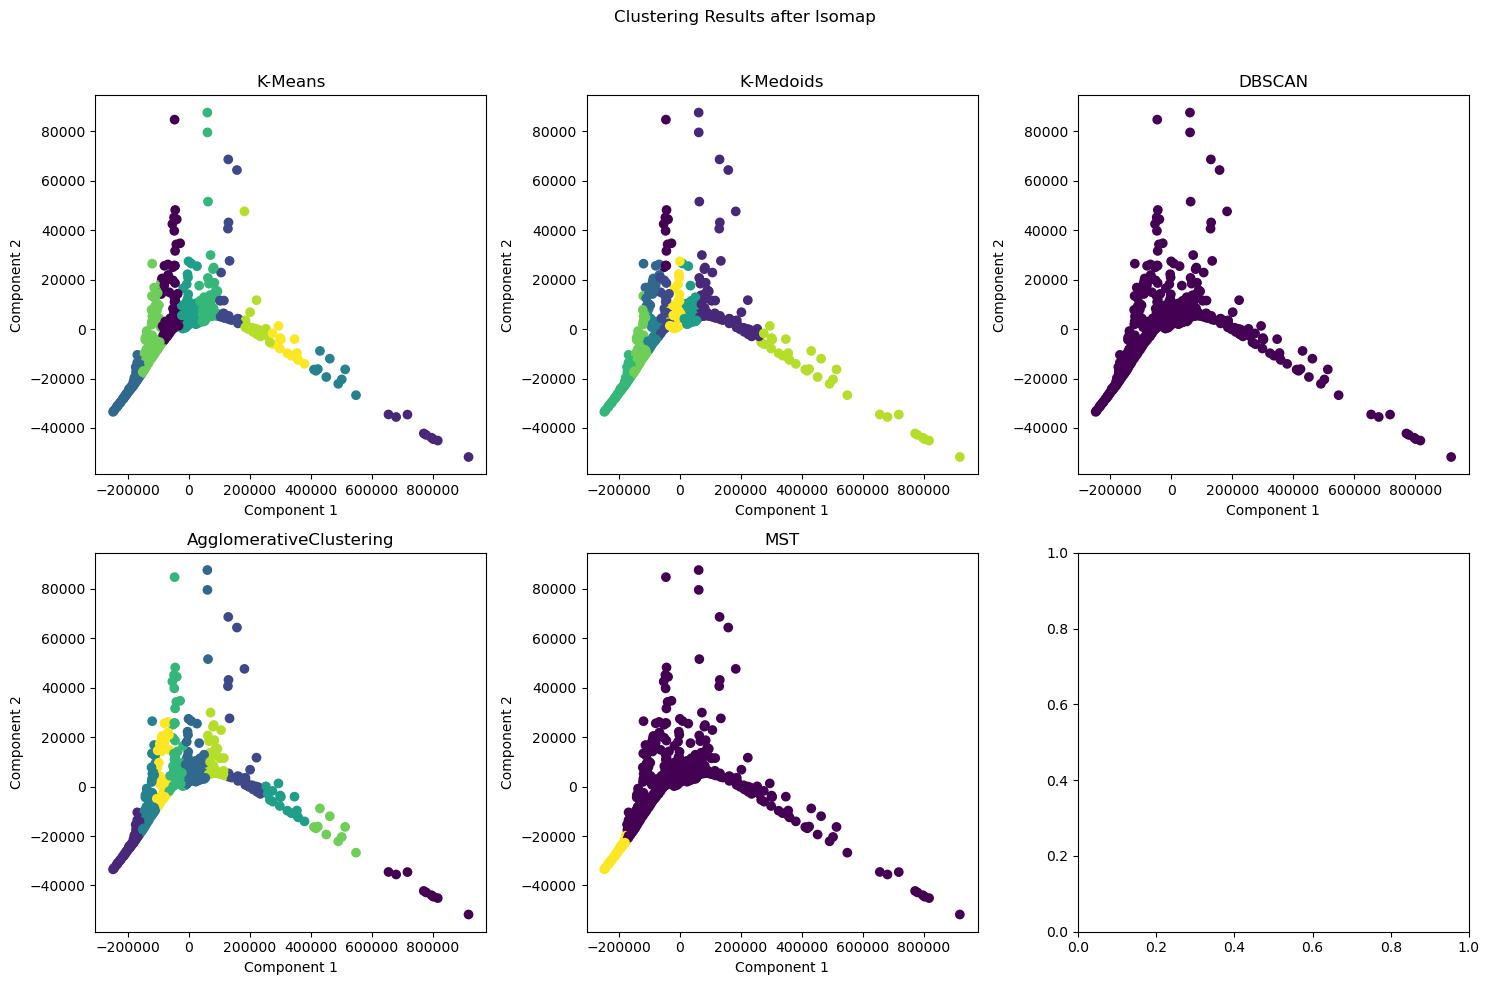


Results for Dimensionality Reduction: Kernel PCA (RBF)

K-Means Silhouette Score: 0.3464
K-Medoids Silhouette Score: 0.0801
DBSCAN could not compute silhouette score because all points belong to a single cluster.
AgglomerativeClustering Silhouette Score: 0.2900
MST could not compute silhouette score because all points belong to a single cluster.


c:\Users\ramte\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


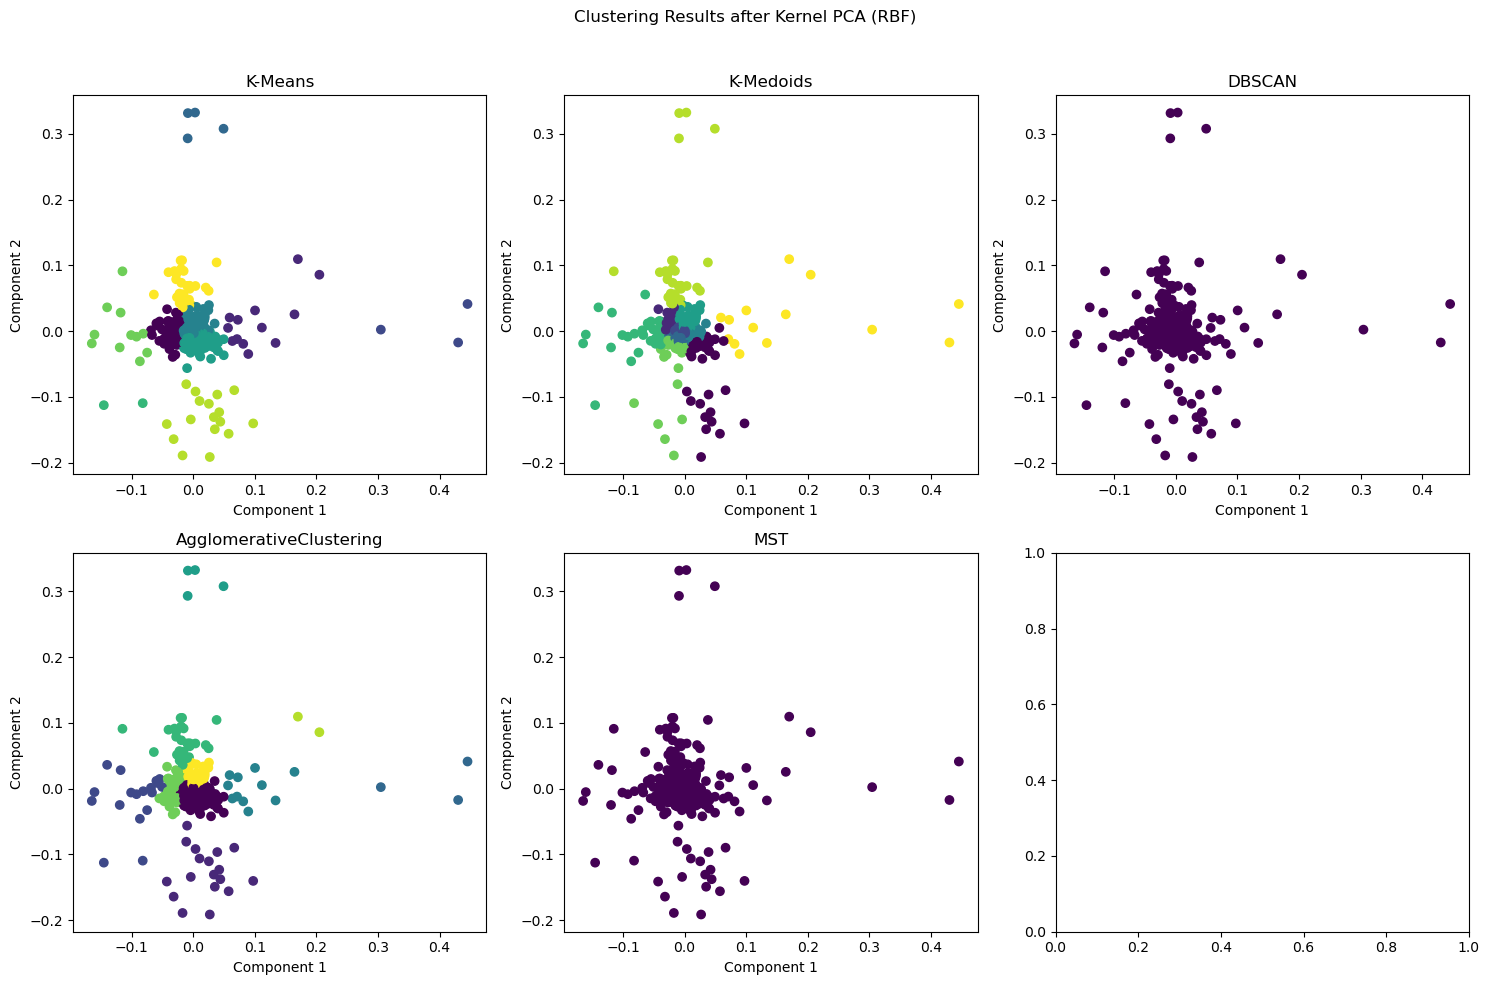


Results for Dimensionality Reduction: LLE

K-Means Silhouette Score: 0.6709
K-Medoids Silhouette Score: 0.6679
DBSCAN could not compute silhouette score because all points belong to a single cluster.
AgglomerativeClustering Silhouette Score: 0.6503
MST Silhouette Score: 0.2990


c:\Users\ramte\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


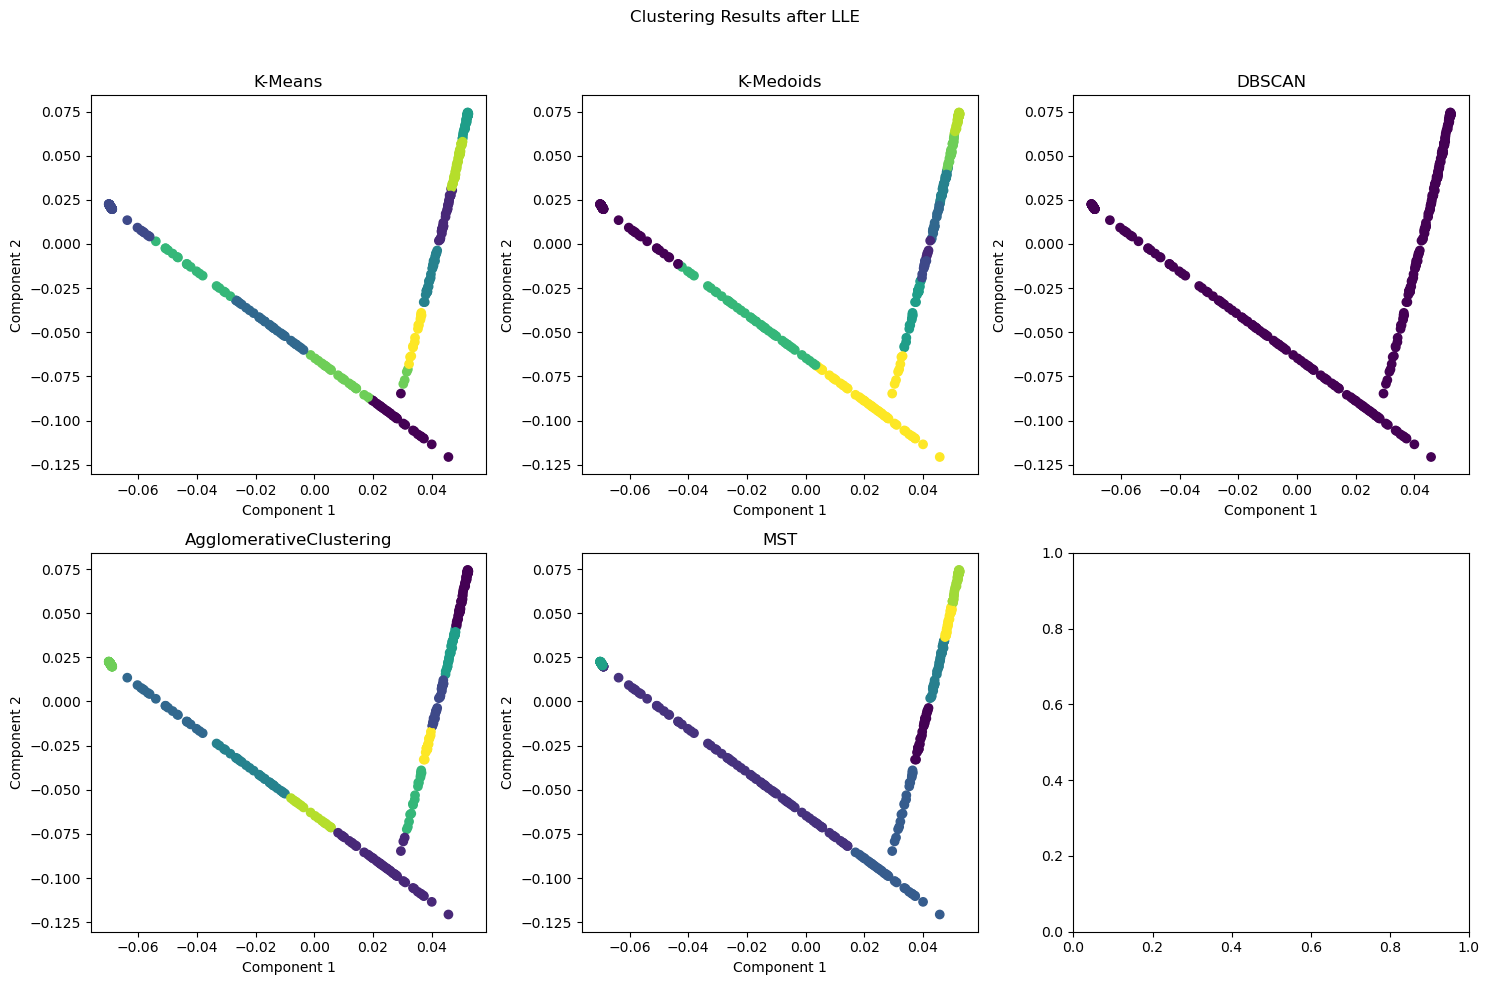


Results for Dimensionality Reduction: Laplacian Eigenmap

K-Means Silhouette Score: 0.6475
K-Medoids Silhouette Score: 0.5670
DBSCAN could not compute silhouette score because all points belong to a single cluster.
AgglomerativeClustering Silhouette Score: 0.6398
MST Silhouette Score: 0.4584


c:\Users\ramte\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


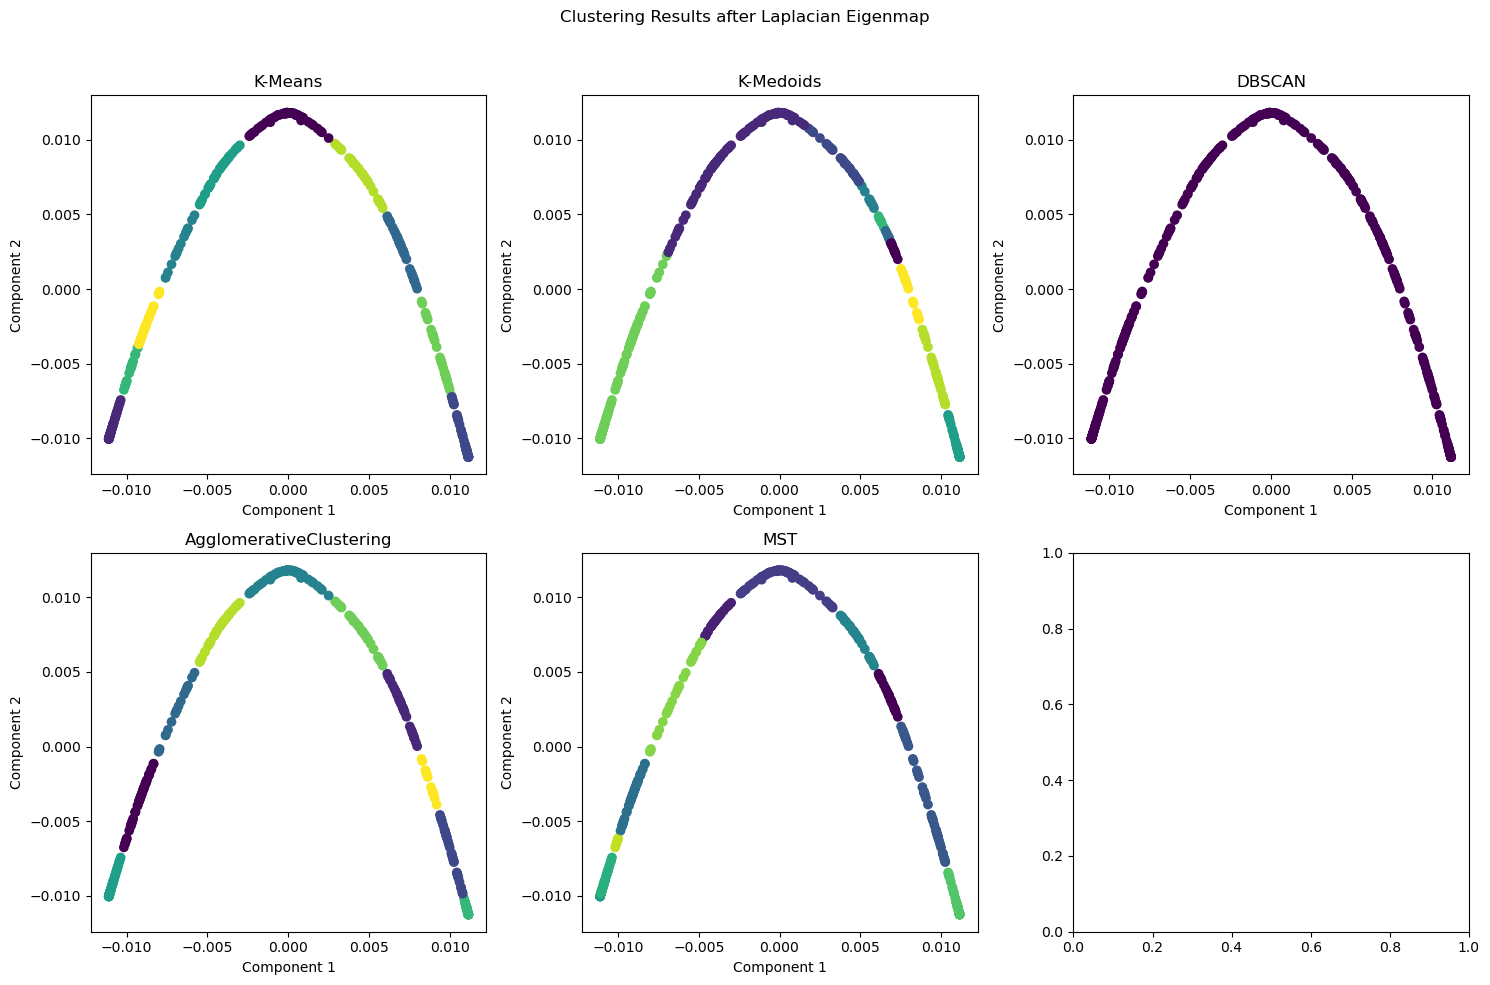


Results for Dimensionality Reduction: t-SNE

K-Means Silhouette Score: 0.5249
K-Medoids Silhouette Score: 0.5070
DBSCAN could not compute silhouette score because all points belong to a single cluster.
AgglomerativeClustering Silhouette Score: 0.5151
MST Silhouette Score: 0.4159


c:\Users\ramte\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


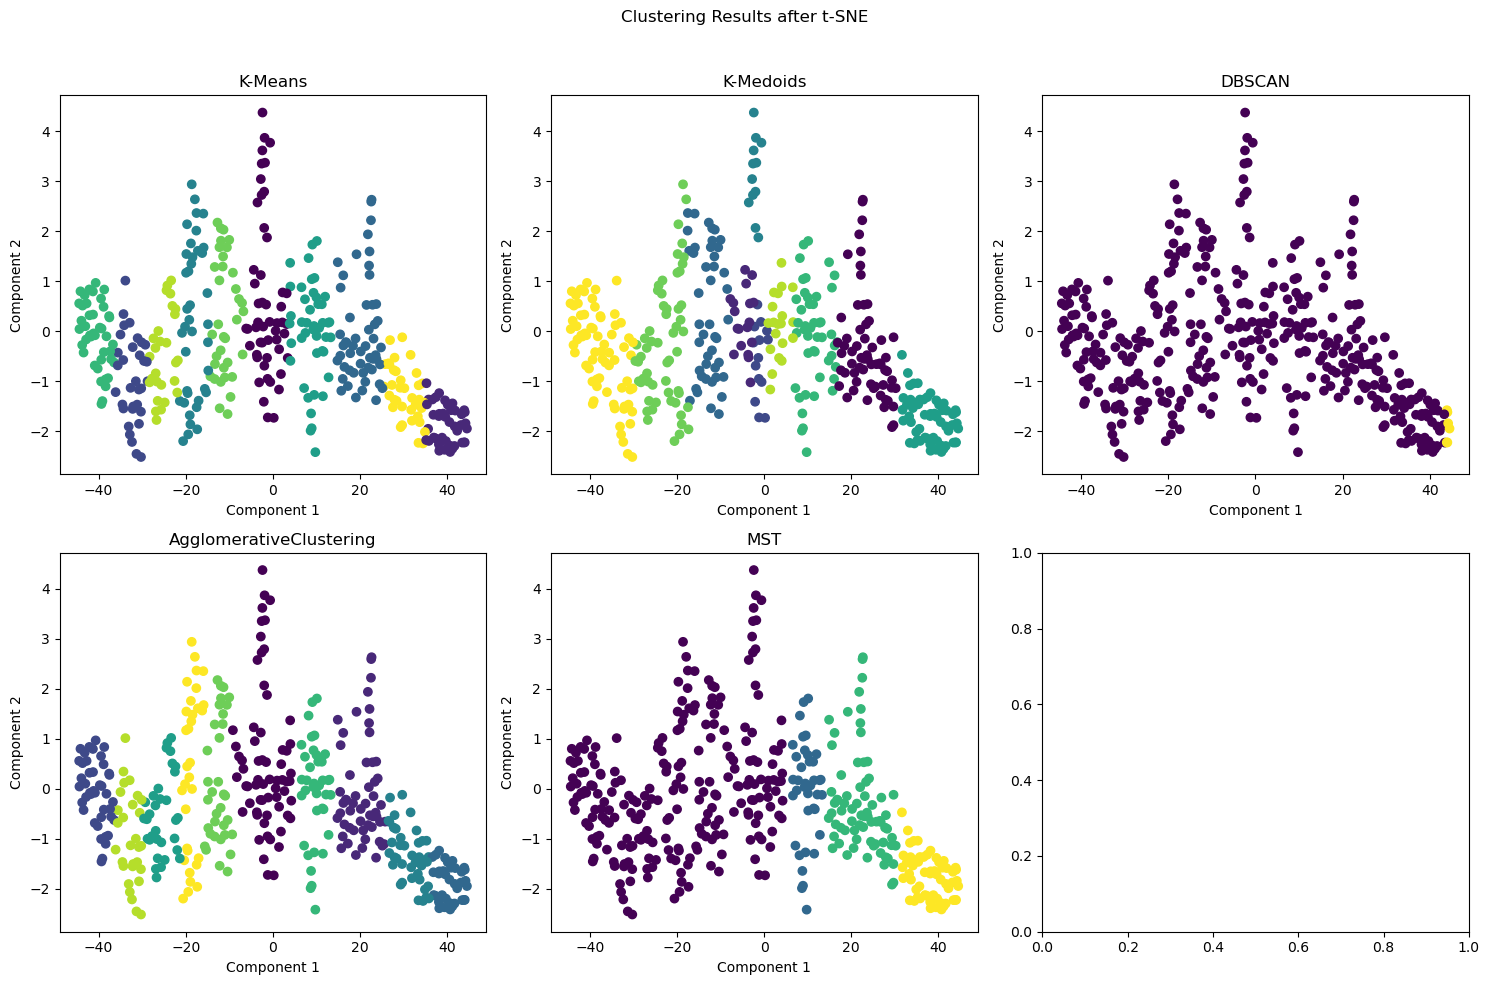


Best Combination: LLE + K-Means with Silhouette Score: 0.6709


In [19]:
best_combination, best_labels = evaluate_dim_reduction_and_clustering(X, dim_reduction_methods, clustering_methods, method_names)